In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import os
import pandas as pd

%run "C:\\Users\\David\\Documents\\GitHub\\wm_distractor_filtering\\psychophysics\\Funciones.ipynb"

from numpy import loadtxt, shape, array, zeros, delete, argsort, mean, std, unique
import itertools
from itertools import chain
import matplotlib.pyplot as plt
import pickle
from pickle import *
import statsmodels.formula.api as sm
from scipy.stats import norm, ttest_1samp
import os
import seaborn as sns
from scipy.stats import norm, ttest_1samp
from numpy import polyfit, poly1d
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scikits.bootstrap import ci
import scikit_posthocs as sp
import ptitprince as pt

Move to results directory and append all excel files into one dataframe

In [33]:
#os.chdir('results')
files=[]
for file in os.listdir():
    files.append(pd.read_excel(file))

df=pd.concat(files, ignore_index=True)
df

,A_T,A_Dist,delay1,delay2,distance,order,cw_ccw,A_R,A_err,RT,...,time_to_fixate,presentation_att_cue_time,presentation_target_time,presentation_dist_time,start_delay1,start_delay2,start_response,response_time,name,session
0,52,69,1,1.65,17,1,cw,47.958722,4.041278,2.827555,...,1.234,1.234,2.268,3.645,2.634044,4.009587,5.679200,8.506755,david,1
1,287,307,1,3.00,20,2,cw,295.328644,-8.328644,1.562308,...,8.925,8.925,11.331,9.955,10.318668,11.694701,14.716819,16.279127,david,1
2,95,81,1,3.00,14,2,ccw,99.935098,-4.935098,2.440041,...,16.716,16.716,19.122,17.745,18.109882,19.487117,22.509652,24.949693,david,1
3,20,49,1,3.00,29,2,cw,24.851586,-4.851586,2.076459,...,25.559,25.559,27.965,26.587,26.952155,28.328148,31.348974,33.425433,david,1
4,314,337,1,1.65,23,1,cw,327.022277,-13.022277,2.783762,...,34.000,34.000,35.028,36.405,35.393176,36.770423,38.441341,41.225104,david,1
5,97,120,1,1.65,23,1,cw,104.079033,-7.079033,3.435483,...,41.808,41.808,42.836,44.213,43.200360,44.576628,46.247968,49.683451,david,1
6,53,38,1,3.00,15,2,ccw,51.283659,1.716341,2.400336,...,50.050,50.050,52.455,51.078,51.442294,52.819476,55.840868,58.241204,david,1
7,86,73,1,1.65,13,1,ccw,86.245348,-0.245348,2.264291,...,58.792,58.792,59.820,61.196,60.184344,61.559564,63.230412,65.494703,david,1
8,190,161,1,3.00,29,2,ccw,194.124323,-4.124323,2.643561,...,65.999,65.999,68.405,67.029,67.393787,68.768295,71.789373,74.432935,david,1
9,143,115,1,1.65,28,1,ccw,151.404035,-8.404035,1.690762,...,75.191,75.191,76.224,77.599,76.587770,77.962977,79.633566,81.324328,david,1


Remove outliers.  
Keep 95% of data based on absolute angle error.  
Remove outliers by subject (I am not setting a limit of wrong).

In [34]:
#Remove out of 95%
df['A_err_abs'] = abs(df['A_err']) 
print(len(df))
frames=[]

for Subject in df.name.unique():
    sub_group=df.groupby('name').get_group(Subject)
    interval = sub_group.quantile([0.95]).unstack(level=1)
    interval = interval['A_err_abs']
    #removed_out = sub_group.loc[(sub_group['A_err_abs']>interval.iloc[0]) & (sub_group['A_err_abs']<interval.iloc[1])] 
    keep = sub_group.loc[sub_group['A_err_abs']<interval.iloc[0]] 
    frames.append(  keep   )
    
    #Print the result
    before_outliers=len(sub_group)
    after_outliers=len(keep)
    print('Outliers in ' + str(Subject) + ' = ' +str(before_outliers-after_outliers)  )  


    
df = pd.concat(frames, ignore_index=True)
print(len(df))

180
Outliers in david = 9
171


In [41]:
def circ_dist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)


def Interference_effects(target, response, reference):
    #input list of target, list of responses and list of references
    #Error_interference; positive for attraction and negative for repulsion
    #######
    #Decimals to get
    decimals=3
    ####
    interferences=[]
    for i in range(0, len(target)):
        angle_err_abs=abs(circ_dist(target[i],response[i]))
        if circ_dist(array(response)[i], array(reference)[i])<=circ_dist(array(target)[i], array(reference)[i]):
            Err_interference=round( angle_err_abs, decimals) 
        else:
            Err_interference=round( -angle_err_abs, decimals)

        interferences.append(Err_interference)
    
    return interferences



inteference = Interference_effects(list(df['A_T']), list(df['A_R']), list(df['A_Dist']) )
df['interference']= inteference

Calculate the distance angle error

In [35]:
##### distance cw-ccw
means_cw={}

for Subj in df.name.unique():
    d_subj = df.groupby('name').get_group(Subj)
    for ori in ['cw', 'ccw']:
        for order in df.order.unique():
            mean_cw = round(d_subj.loc[ (d_subj['cw_ccw']==ori)  & (d_subj['order']==order), 'A_err'   ].mean(), 3)
            means_cw[str(Subj)  + '_' + str(order) + '_' + ori] = mean_cw
                

        
cw_ccw_distance=[]

for i in df.index:
    or_ = df.loc[i, 'cw_ccw']
    if or_ == 'cw':
        or_cont = 'ccw'
    elif or_ =='ccw':
        or_cont = 'cw' 
    else:
        print('Error')
    idx =  str(df.loc[i, 'name'])+ '_' + str(df.loc[i, 'order']) +'_' + or_cont
    #
    if or_ == 'ccw':
        cw_ccw_distance.append( (df.loc[i, 'A_err'] - means_cw[idx])/2 )  
    elif or_ =='cw':
        cw_ccw_distance.append( (means_cw[idx] - df.loc[i, 'A_err'])/2 )  
    else:
        print('Error')
    


df['distance_A_err'] = cw_ccw_distance

In [36]:
df.head(10)

,A_T,A_Dist,delay1,delay2,distance,order,cw_ccw,A_R,A_err,RT,...,presentation_target_time,presentation_dist_time,start_delay1,start_delay2,start_response,response_time,name,session,A_err_abs,distance_A_err
0,52,69,1,1.65,17,1,cw,47.958722,4.041278,2.827555,...,2.268,3.645,2.634044,4.009587,5.679200,8.506755,david,1,4.041278,-3.878139
1,287,307,1,3.00,20,2,cw,295.328644,-8.328644,1.562308,...,11.331,9.955,10.318668,11.694701,14.716819,16.279127,david,1,8.328644,3.624322
2,95,81,1,3.00,14,2,ccw,99.935098,-4.935098,2.440041,...,19.122,17.745,18.109882,19.487117,22.509652,24.949693,david,1,4.935098,-0.735049
3,20,49,1,3.00,29,2,cw,24.851586,-4.851586,2.076459,...,27.965,26.587,26.952155,28.328148,31.348974,33.425433,david,1,4.851586,1.885793
4,314,337,1,1.65,23,1,cw,327.022277,-13.022277,2.783762,...,35.028,36.405,35.393176,36.770423,38.441341,41.225104,david,1,13.022277,4.653638
5,97,120,1,1.65,23,1,cw,104.079033,-7.079033,3.435483,...,42.836,44.213,43.200360,44.576628,46.247968,49.683451,david,1,7.079033,1.682017
6,53,38,1,3.00,15,2,ccw,51.283659,1.716341,2.400336,...,52.455,51.078,51.442294,52.819476,55.840868,58.241204,david,1,1.716341,2.590670
7,86,73,1,1.65,13,1,ccw,86.245348,-0.245348,2.264291,...,59.820,61.196,60.184344,61.559564,63.230412,65.494703,david,1,0.245348,-0.285174
8,190,161,1,3.00,29,2,ccw,194.124323,-4.124323,2.643561,...,68.405,67.029,67.393787,68.768295,71.789373,74.432935,david,1,4.124323,-0.329661
9,143,115,1,1.65,28,1,ccw,151.404035,-8.404035,1.690762,...,76.224,77.599,76.587770,77.962977,79.633566,81.324328,david,1,8.404035,-4.364517


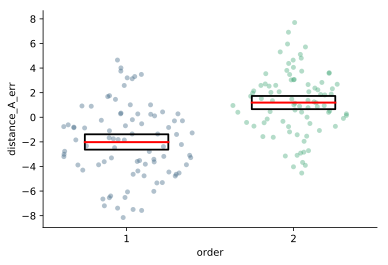

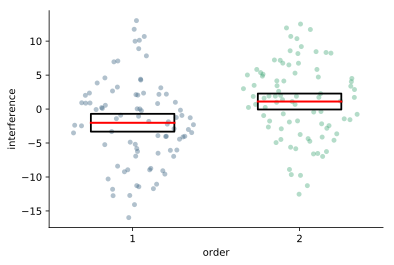

In [43]:
from matplotlib.patches import Rectangle
import scipy
import scikits.bootstrap as bootstraps
from seaborn_sinaplot import sinaplot
from matplotlib.patches import Rectangle

   
    
def linares_plot(x, y, df, pallete, alpha, hue=None):
    sinaplot.sinaplot(x=x, y=y, hue=hue, data=df, violin=False, palette=pallete, alpha=alpha)
    if hue==None:
        for i_x, x_idx in enumerate(df[x].unique()):
            ci = df.groupby(x)[y].apply(lambda n:bootstraps.ci(data=n.values)).iloc[i_x]
            plt.gca().add_patch(Rectangle((i_x+-0.25, ci[0]), 0.5, ci[1]-ci[0],alpha=1, fill=False, linewidth=1.8))
            m = df.loc[df[x]==x_idx, y].mean()
            plt.plot([i_x-0.25, i_x+0.25], [m,m ], 'r', linewidth=2)
    else:
        for i_x, x_idx in enumerate(df[x].unique()):
            for i_h, h_idx in enumerate(df[hue].unique()):
                ci = df.groupby(x).get_group(x_idx).groupby(h)[y].apply(lambda n:bootstraps.ci(data=n.values)).iloc[i_h]
                if i_h==0:
                    bott_left = i_x - .35 
                else:
                    bott_left = i_x +0.05
                 
                bar_length = 0.6/len(Df[hue].unique())
                plt.gca().add_patch(Rectangle((bott_left, ci[0]), bar_length , ci[1]-ci[0],
                                              alpha=1, fill=False, linewidth=1.8))
                
                m = df.loc[(df[x]==x_idx) & (df[hue]==h_idx) , y].mean()                
                plt.plot( [bott_left, bott_left+bar_length], [m,m ], 'r', linewidth=2)
        
        #
    plt.xticks(  np.arange(len(df[x].unique())) , df[x].unique())
    plt.xlim(-0.5, len(df[x].unique())-0.5 )
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().get_xaxis().tick_bottom()
    plt.gca().get_yaxis().tick_left()
    

    
linares_plot(x='order', y='distance_A_err', df=df, pallete='viridis', alpha=0.4)  
plt.show()

linares_plot(x='order', y='interference', df=df, pallete='viridis', alpha=0.4)  
plt.show()

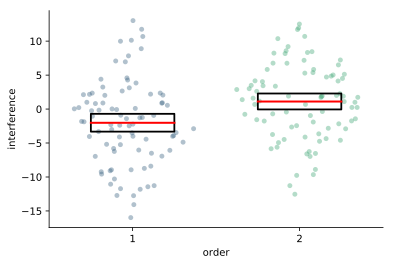